# 2019 DATA SCIENCE BOWL

### Summary
In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. 
Your solutions will aid in discovering important relationships between engagement with high-quality educational media and learning processes.

### Get modules needed

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from IPython.display import HTML
import warnings
pd.set_option('max_columns', 100)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

# set_options set maximum columns to 100
# set stype and increased color palette for charting

### Load Dataset

First we will see what files we are given to work with. Note the train.csv file is quite large at 3.7G. From the data description we know:
- train.csv & test.csv : These are the main data files which contain the gameplay events.
- specs.csv : This file gives the specification of the various event types.
- train_labels.csv : This file demonstrates how to compute the ground truth for the assessments in the training set.
- sample_submission.csv : A sample submission in the correct format.

In [1]:
# List current directory
import os
os.getcwd()

'C:\\Users\\sandra\\Documents\\GitHub'

In [39]:
# Change working directory
os.chdir('c:/Users/sandra/Documents/DataScienceProjects/DataBowl')  
os.getcwd()

'c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl'

In [40]:
# os.listdir()
!ls

 Volume in drive C has no label.
 Volume Serial Number is A013-71D9

 Directory of c:\Users\sandra\Documents\DataScienceProjects\DataBowl

11/21/2019  10:08 AM    <DIR>          .
11/21/2019  10:08 AM    <DIR>          ..
11/21/2019  10:08 AM            11,031 sample_submission.csv
11/21/2019  10:08 AM           408,868 specs.csv
11/21/2019  10:08 AM       398,327,795 test.csv
11/21/2019  10:09 AM     3,878,373,417 train.csv
11/21/2019  10:08 AM         1,124,229 train_labels.csv
               5 File(s)  4,278,245,340 bytes
               2 Dir(s)  159,468,392,448 bytes free


In [18]:
# Read in the data CSV files
train = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\train.csv')
train_labels = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\train_labels.csv')
test = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\test.csv')
specs = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\specs.csv')
ss = pd.read_csv ('c:\\Users\\sandra\\Documents\\DataScienceProjects\\DataBowl\\sample_submission.csv')


The training data is so large, we will take a random sample of it for plotting. Since we are doing this at random it will speed up the time it takes to plot but still give us a a good view of the data's format. Later, can load the data in as manageable
bits and then do the same plotting procedure.

In [19]:
train_ = train.sample(1000000) #sample 1M observations

### What are we predicting?

First we will look at the target we intend to predict.

We are told: The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt). 

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):
- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved

In [20]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


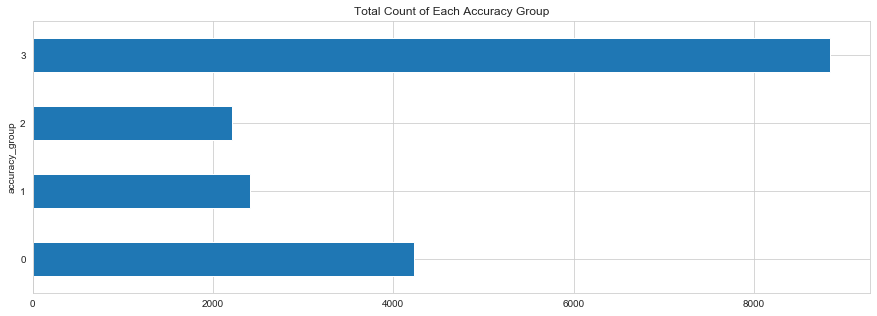

In [33]:
# Get a count of how many instances for 0,1,2,3 in accuracy_group
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Total Count of Each Accuracy Group')
plt.show()

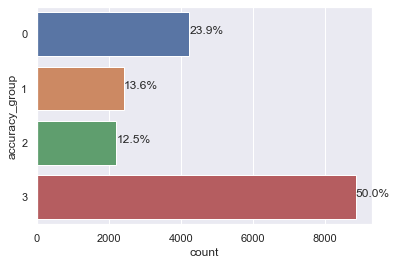

In [64]:
# Get a count of how many instances for 0,1,2,3 in accuracy_group BUT WITH LABELS beside bars and not using pandas
%matplotlib inline
sns.set(style="darkgrid")
ax = sns.countplot(y='accuracy_group',  data=train_labels)

total = len(train_labels['accuracy_group'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
plt.show()
    
    


### Notes about accuracy_group
- Accuracy_group 3 (which is right on the first attempt) accounts for 50% of the total count.
- Accuracy_group 2 & 1 accounts for approximately 13% each.
- Accuracy_group 0 account for approximately 25%
- These percentage values can be used as a judge to determine if the difficulty of the questions should be harder or easier. For example, if it is desired to have "easier" questions then accuracy_group 3 should make up a larger %.
- The percentage of each accuracy_group can be used as a rough guide to forecast the number of attempts. Since 50% of the time they will get it right on the first attempt, 13% of the time will be 1 attempt, 13% of the time will be 3 or more attempts and 25% of the time will not be solved.


### Examine the values in accuracy group 3 in more detail since it is the bulk of the total count
Want to get an idea of num_incorrect (or number of attempts) within accuracy group 3.

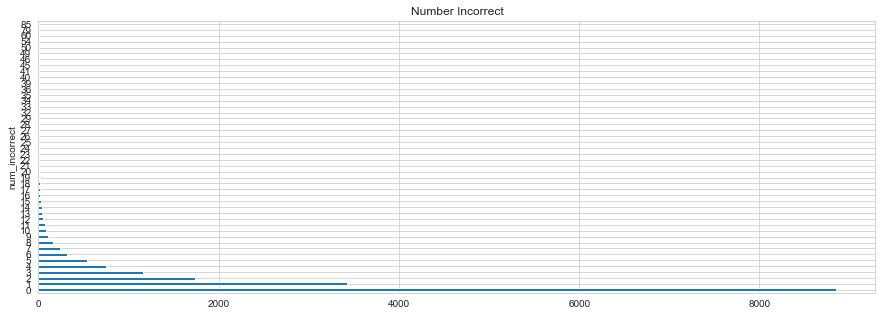

In [34]:
train_labels.groupby('num_incorrect')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Number Incorrect')
plt.show()


The chart has too many values on at the lower extremes to get a good idea of what the higher extremes are.

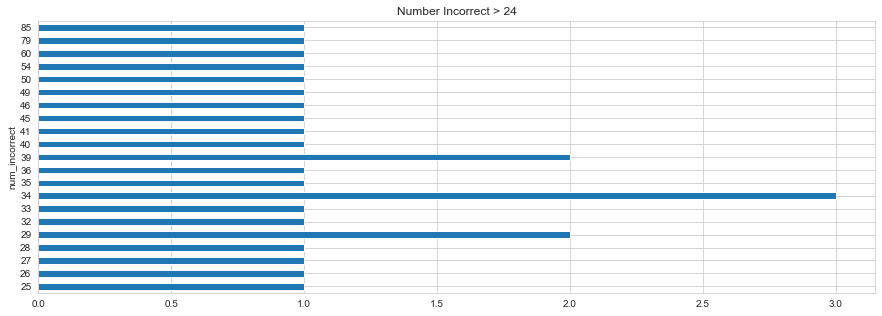

In [49]:
# Separate the number incorrect to only include those above 15
high_values = train_labels[(train_labels['num_incorrect'] > 24)]
high_values.groupby('num_incorrect')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Number Incorrect > 24')
plt.show()

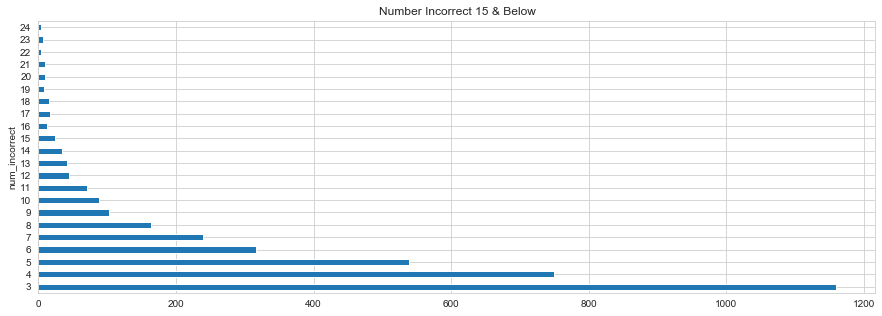

In [50]:
# Separate the number incorrect to only include values between 3 & 24
high_values = train_labels[(train_labels['num_incorrect'] >= 3) & (train_labels['num_incorrect'] <=24)]
high_values.groupby('num_incorrect')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Number Incorrect 15 & Below')
plt.show()

- After breaking the chart up, it can be seen that the majority over 25 are just one instance so excluding them should be considered.
- Realistically speaking, a child is very unlikely to try 85 times to get a problem correct. But what would  

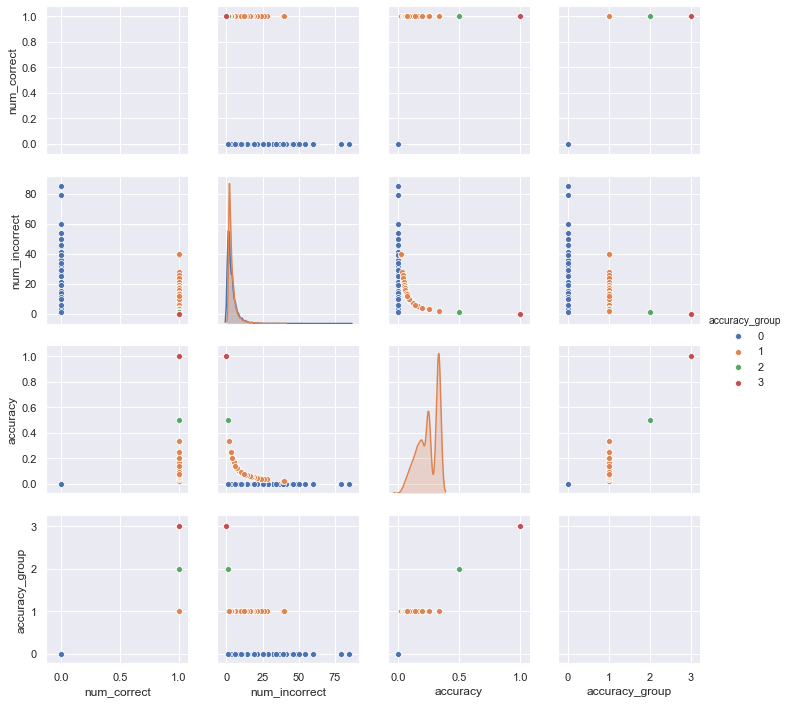

In [65]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

I'm not sure what I can see from the pairplot? Maybe after I will notice something.

## train.csv / test.csv
The data provided in these files are as follows:

- event_id - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- game_session - Randomly generated unique identifier grouping events within a single game or video play session.
- timestamp - Client-generated datetime
- event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise - fields are determined by the event type.
- installation_id - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- event_count - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- event_code - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- game_time - Time in milliseconds since the start of the game session. Extracted from event_data.
- title - Title of the game or video.
- type - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- world - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [67]:
# Take a look at the training file
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [68]:
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

## My IDEAS:
- Look for outliers because a child may leave the program idle.
- See if time idle correlaets with # incorrect.
- Can I merge the dataset or do I want to?
- The score will definitely depend on the game type (or title) because some will be inherently more difficult than others.
- Under train